In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import nc_time_axis
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("paper",font_scale=1.2)
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import xskillscore as xs
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob
import datetime
import time
import multiprocessing
import zipfile
import palettable

# get my own stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

from IPython.display import display, clear_output

%matplotlib inline

In [2]:
## matplotlib RCparams setup

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',list(get_palette.Petroff10().to_sn_palette()))
matplotlib.rcParams['font.family']='Helvetica Neue'
matplotlib.rcParams['legend.frameon']=False
plt.rcParams['pdf.fonttype'] = 42

In [3]:
## plotting functions:

def add_lat_lon_ticks(ax,lat=True,lon=True, lon_ext=[-180,181], lat_ext=[-90,91]):
    if lon:
        ax.set_xticks(np.arange(*lon_ext,30), crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    if lat:
        ax.set_yticks(np.arange(*lat_ext,10), crs=crs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

### get meta & lsm for ExSamples, UKCP

In [4]:
## ExSamples data location:
ExS_dataloc = '../../ExSamples_product/20210622/'

## create a run_info dataframe
run_info = pd.DataFrame(data=[['05','10','15'],['2072','2068','2066'],['r001i1p01554','r001i1p02242','r001i1p02868'],['hot','wet','hot']],
                        index=['ensemble_member','year','run','type'],columns=['fut_2072','fut_2068','fut_2066']).T

run_info['label'] = ['HOT2','WET','HOT1']

## get land sea masks
ExS_GBR_lsm = xr.open_dataarray('../ancil/ExS_GBR_lsm.nc')
UKCP_GBR_lsm = xr.open_dataarray('../ancil/UKCP_GBR_lsm.nc',decode_times=False)
UKCP_glob_lsm = xr.open_dataarray('../ancil/UKCP_lsm.nc',decode_times=False).astype(bool)

## create a dict of UKCP PPE experiment subsamples
UKCP_experiment_list = {}
UKCP_experiment_list[10] = ['0000','1113','1554','1649','1843','1935','2123','2242','2491','2868']
UKCP_experiment_list[12] = ['0000','1113','1554','1649','1843','1935','2123','2242','2305','2335','2491','2868']
UKCP_experiment_list[15] = ['0000', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2123', '2242', '2305', '2335', '2491', '2832', '2868']
UKCP_experiment_list[13] = ['0000', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2123', '2242', '2491', '2832', '2868']
UKCP_experiment_list[20] = ['0000', '0090', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2089', '2123', '2242', '2305', '2335', '2491', '2753', '2832', '2868', '2884', '2914']

## create a colour palette if required.
choose_palette = [matplotlib.colors.to_hex(get_palette.IBM_color_blind().to_sn_palette()[i]) for i in [2,0,3]]

## other options:
### IBM color blind
# [matplotlib.colors.to_hex(get_palette.IBM_color_blind().to_sn_palette()[i]) for i in [2,0,3]]
### Petroff 6
# [matplotlib.colors.to_hex(get_palette.Petroff6().to_sn_palette()[i]) for i in [1,0,2]]
### tab10
# [matplotlib.colors.to_hex(get_palette.tab10().to_sn_palette()[i]) for i in [1,0,2]]

winter_colors = pd.Series(index=['1554','2242','2868'],data=choose_palette)

## Get UKCP data

In [5]:
## now we grab baseline & future runs from UKCP
def preproc_UKCP(ds):
    # selects DJF & averages over
    ds = ds.squeeze().sel(latitude=slice(50,61),longitude=slice(-12,2)).expand_dims('ensemble_member_id')
    ds = ds.sel(time = ds['time.month'].isin([12,1,2])).resample(time='QS-DEC').mean()
    ds = ds.sel(time = ds['time.month']==12)
    return ds

UKCP_txm = xr.open_mfdataset([glob.glob('/badc/ukcp18/data/land-gcm/global/60km/rcp85/'+"{:02d}".format(x)+'/tasmax/mon/latest/*')[0] for x in np.arange(1,16)],preprocess=preproc_UKCP)

In [6]:
## average over UK land:
UKCP_GBR_lsm_slice = UKCP_GBR_lsm.sel(latitude=slice(50,61),longitude=slice(-12,2)).assign_coords(latitude=UKCP_txm.latitude,longitude=UKCP_txm.longitude)

UKCP_txm_df = UKCP_txm.tasmax.where(UKCP_GBR_lsm_slice).weighted(np.cos(np.deg2rad(UKCP_GBR_lsm_slice.latitude))).mean(['latitude','longitude']).to_pandas()
UKCP_txm_df.columns = [x.decode()[-4:] for x in UKCP_txm_df.columns]

convert columns to the winter years

In [7]:
UKCP_txm_df.index = np.arange(1900,2100)

In [8]:
UKCP_mem_map = dict(zip([int('11'+x.decode().split('-')[-1].split('p')[-1]) for x in UKCP_txm.ensemble_member_id.values],UKCP_txm.ensemble_member_id.values))

In [9]:
## get UKCP precip
def preproc_UKCP_precip(ds):
    # selects DJF & averages over
    if not ds.realization.values[()] in UKCP_mem_map.keys():
        return None
    ds = ds.expand_dims('realization').rename(dict(realization='ensemble_member_id',precipitation_flux='pr')).assign_coords(ensemble_member_id=[UKCP_mem_map[ds.realization.values[()]]])
#     ds = ds.resample(time='MS',loffset=pd.Timedelta(15, 'd')).mean()
#     ds = ds.sel(time = ds['time.month'].isin([12,1,2]))
    return ds

UKCP_precip_scaling = 1000/997*(3600*24) # convert to mm -> per day

UKCP_pr = xr.concat([x.chunk({'ensemble_member_id':1}) for x in [preproc_UKCP_precip(xr.open_dataset(x)) for x in sorted(glob.glob('/home/users/njleach/UKCP_hadgem3_data/pr/*.nc'))] if x is not None],'ensemble_member_id')*UKCP_precip_scaling

In [10]:
# convert to seasonal mean timeseries
UKCP_prm = UKCP_pr.resample(time='QS-DEC').mean()
UKCP_prm = UKCP_prm.sel(time=UKCP_prm['time.month']==12)

/home/users/njleach/miniconda3/lib/python3.9/site-packages/dask/array/core.py:4337: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(


In [11]:
UKCP_prm_df = UKCP_prm.pr.where(UKCP_GBR_lsm_slice).weighted(np.cos(np.deg2rad(UKCP_GBR_lsm_slice.latitude))).mean(['latitude','longitude']).to_pandas()
UKCP_prm_df.columns = [x.decode()[-4:] for x in UKCP_prm_df.columns]

convert columns to the winter years

In [12]:
UKCP_prm_df.index = np.arange(1900,2100)

## Create detrended equivalents

In [13]:
txm_olse = OLSE.simple(UKCP_txm_df.loc[2061:2080])
txm_olse.fit(np.arange(20)[:,None])

UKCP_txm_detrend_df = pd.DataFrame().reindex_like(UKCP_txm_df.loc[2061:2080]).fillna(0) + txm_olse.res.data

prm_olse = OLSE.simple(UKCP_prm_df.loc[2061:2080])
prm_olse.fit(np.arange(20)[:,None])

UKCP_prm_detrend_df = pd.DataFrame().reindex_like(UKCP_prm_df.loc[2061:2080]).fillna(0) + prm_olse.res.data

## Create lineplot

''

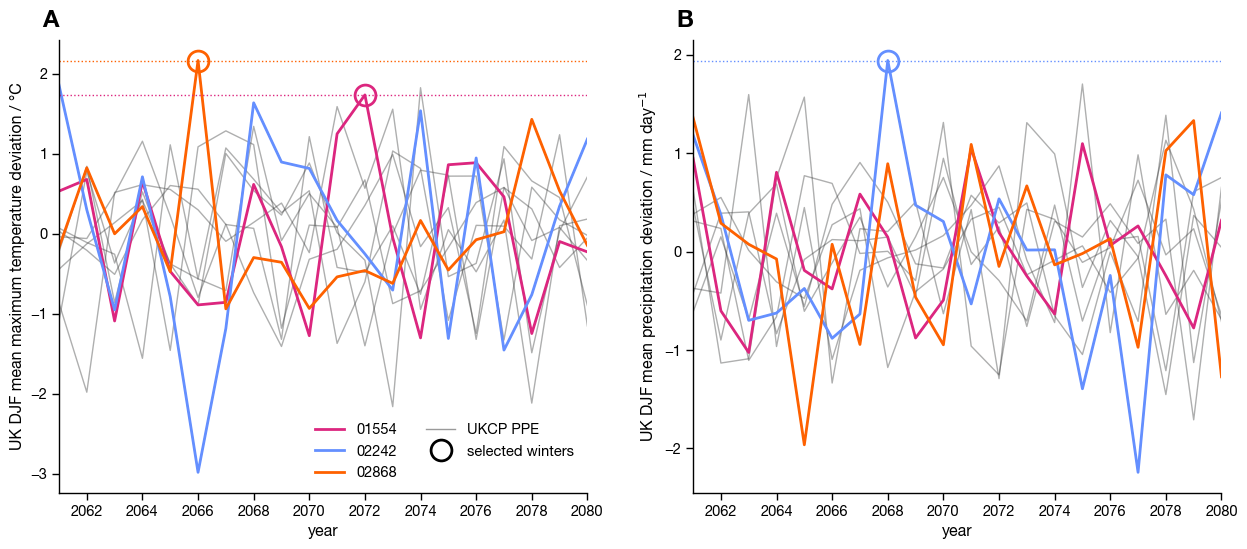

In [14]:
fig,ax = plt.subplots(1,2,figsize=(15,6))

## ALL UKCP deviations
UKCP_txm_detrend_df.loc[2061:2080,UKCP_experiment_list[10]].plot(ax=ax[0],color='xkcd:dark grey',lw=1,alpha=0.4,legend=False)

## Selected ensemble member deviations
for winter,color in winter_colors.iteritems():
    UKCP_txm_detrend_df.loc[2061:2080,winter].plot(ax=ax[0],color=color,lw=2,legend=False)
    
## Selected winter deviations
ax[0].axhline(UKCP_txm_detrend_df.loc[2066,'2868'],color=winter_colors.loc['2868'],lw=1,ls=':')
ax[0].axhline(UKCP_txm_detrend_df.loc[2072,'1554'],color=winter_colors.loc['1554'],lw=1,ls=':')

ax[0].plot(2066,UKCP_txm_detrend_df.loc[2066,'2868'],mec=winter_colors.loc['2868'],marker='o',mfc='none',ms=15,mew=2)
ax[0].plot(2072,UKCP_txm_detrend_df.loc[2072,'1554'],mec=winter_colors.loc['1554'],marker='o',mfc='none',ms=15,mew=2)
    
## ALL UKCP deviations
UKCP_prm_detrend_df.loc[2061:2080,UKCP_experiment_list[10]].plot(ax=ax[1],color='xkcd:dark grey',lw=1,alpha=0.4,legend=False)

## Selected ensemble member deviations
for winter,color in winter_colors.iteritems():
    UKCP_prm_detrend_df.loc[2061:2080,winter].plot(ax=ax[1],color=color,lw=2,legend=False)
    
## Selected winter deviations
ax[1].axhline(UKCP_prm_detrend_df.loc[2068,'2242'],color=winter_colors.loc['2242'],lw=1,ls=':')

ax[1].plot(2068,UKCP_prm_detrend_df.loc[2068,'2242'],mec=winter_colors.loc['2242'],marker='o',mfc='none',ms=15,mew=2)
    
## axes properties
for a in ax:
    a.set_xlim(2061,2080)
    a.set_xticks(np.arange(2062,2081,2))
    
## axes labels
[a.set_xlabel('year') for a in ax]
ax[0].set_ylabel('UK DJF mean maximum temperature deviation / \N{DEGREE SIGN}C')
ax[1].set_ylabel('UK DJF mean precipitation deviation / mm day$^{-1}$')
    
## legend handles
ax[0].plot([],[],color=winter_colors.loc['1554'],lw=2,label=run_info.loc['fut_2072','run'][-5:])
ax[0].plot([],[],color=winter_colors.loc['2242'],lw=2,label=run_info.loc['fut_2068','run'][-5:])
ax[0].plot([],[],color=winter_colors.loc['2868'],lw=2,label=run_info.loc['fut_2066','run'][-5:])
ax[0].plot([],[],color='xkcd:dark grey',lw=1,alpha=0.5,label='UKCP PPE')
ax[0].plot([],[],mec='k',lw=0,marker='o',mfc='none',ms=15,mew=2,label='selected winters')

ax[0].legend(*[x[-5:] for x in ax[0].get_legend_handles_labels()],frameon=False,loc=4,ncol=2)

sn.despine()

[ax[i].text(0.0,1.02,x,transform=ax[i].transAxes,va='bottom',ha='right',fontsize='xx-large',fontweight='bold') for i,x in enumerate(['A','B'])]

fig.dpi=100

[fig.savefig('../output/figs/FIG1.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

Identical figure but plotting anomalies rather than deviations:

''

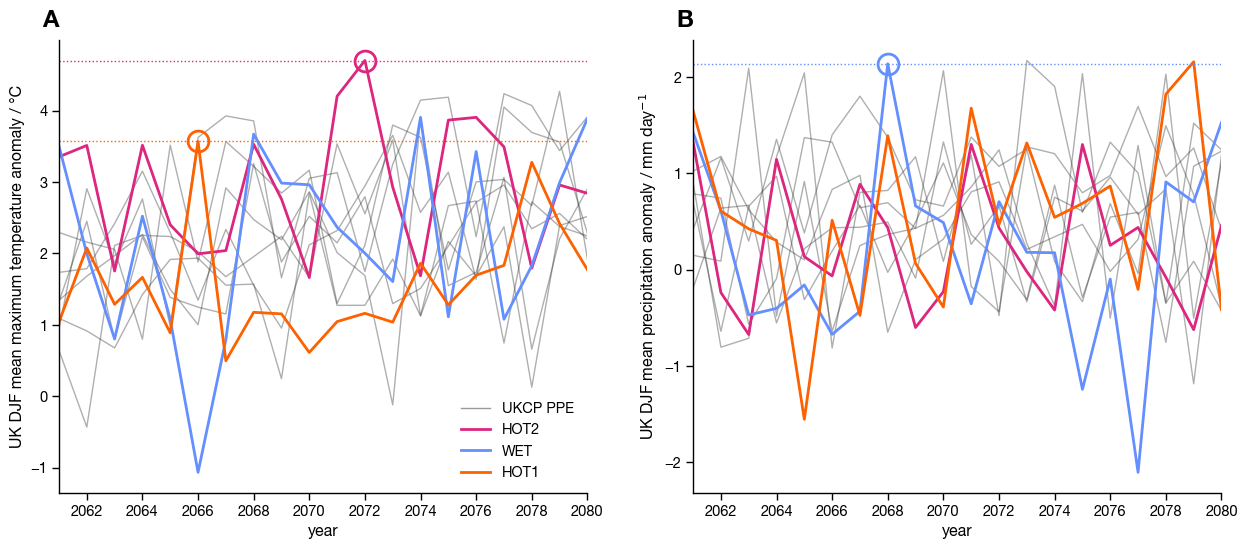

In [15]:
fig,ax = plt.subplots(1,2,figsize=(15,6))

## ALL UKCP deviations
(UKCP_txm_df.loc[2061:2080,UKCP_experiment_list[10]]-UKCP_txm_df.loc[1997:2026,UKCP_experiment_list[10]].mean()).plot(ax=ax[0],color='xkcd:dark grey',lw=1,alpha=0.4,legend=False)

## Selected ensemble member deviations
for winter,color in winter_colors.iteritems():
    (UKCP_txm_df.loc[2061:2080,winter]-UKCP_txm_df.loc[1997:2026,winter].mean()).plot(ax=ax[0],color=color,lw=2,legend=False)
    
## Selected winter deviations
ax[0].axhline(UKCP_txm_df.loc[2066,'2868']-UKCP_txm_df.loc[1997:2026,'2868'].mean(),color=winter_colors.loc['2868'],lw=1,ls=':')
ax[0].axhline(UKCP_txm_df.loc[2072,'1554']-UKCP_txm_df.loc[1997:2026,'1554'].mean(),color=winter_colors.loc['1554'],lw=1,ls=':')

ax[0].plot(2066,UKCP_txm_df.loc[2066,'2868']-UKCP_txm_df.loc[1997:2026,'2868'].mean(),mec=winter_colors.loc['2868'],marker='o',mfc='none',ms=15,mew=2)
ax[0].plot(2072,UKCP_txm_df.loc[2072,'1554']-UKCP_txm_df.loc[1997:2026,'1554'].mean(),mec=winter_colors.loc['1554'],marker='o',mfc='none',ms=15,mew=2)
    
## ALL UKCP deviations
(UKCP_prm_df.loc[2061:2080,UKCP_experiment_list[10]]-UKCP_prm_df.loc[1997:2026,UKCP_experiment_list[10]].mean()).plot(ax=ax[1],color='xkcd:dark grey',lw=1,alpha=0.4,legend=False)

## Selected ensemble member deviations
for winter,color in winter_colors.iteritems():
    (UKCP_prm_df.loc[2061:2080,winter]-UKCP_prm_df.loc[1997:2026,winter].mean()).plot(ax=ax[1],color=color,lw=2,legend=False)
    
## Selected winter deviations
ax[1].axhline(UKCP_prm_df.loc[2068,'2242']-UKCP_prm_df.loc[1997:2026,'2242'].mean(),color=winter_colors.loc['2242'],lw=1,ls=':')

ax[1].plot(2068,UKCP_prm_df.loc[2068,'2242']-UKCP_prm_df.loc[1997:2026,'2242'].mean(),mec=winter_colors.loc['2242'],marker='o',mfc='none',ms=15,mew=2)
    
## axes properties
for a in ax:
    a.set_xlim(2061,2080)
    a.set_xticks(np.arange(2062,2081,2))
    
## axes labels
[a.set_xlabel('year') for a in ax]
ax[0].set_ylabel('UK DJF mean maximum temperature anomaly / \N{DEGREE SIGN}C')
ax[1].set_ylabel('UK DJF mean precipitation anomaly / mm day$^{-1}$')
    
## legend handles
ax[0].plot([],[],color='xkcd:dark grey',lw=1,alpha=0.5,label='UKCP PPE')
ax[0].plot([],[],color=winter_colors.loc['1554'],lw=2,label=run_info.loc['fut_2072','label'])
ax[0].plot([],[],color=winter_colors.loc['2242'],lw=2,label=run_info.loc['fut_2068','label'])
ax[0].plot([],[],color=winter_colors.loc['2868'],lw=2,label=run_info.loc['fut_2066','label'])

ax[0].legend(*[x[-4:] for x in ax[0].get_legend_handles_labels()],frameon=False,loc=4)

sn.despine()

[ax[i].text(0.0,1.02,x,transform=ax[i].transAxes,va='bottom',ha='right',fontsize='xx-large',fontweight='bold') for i,x in enumerate(['A','B'])]

fig.dpi=100
''